In [9]:

from advectionGP.models import AdjointAdvectionDiffusionModel as model
from advectionGP.sensors import FixedSensorModel
from advectionGP.kernels import EQ
from advectionGP.test import TestKernels

import numpy as np
import matplotlib.pyplot as plt

# generate sensor locations with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,7,5) # lower time
xloc=np.linspace(0.5,19,5) # x locations
yloc=np.linspace(0.5,19,5) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] 
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1]
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2]
X[:,1] = X[:,0]+1

N_feat=200 # number of features used to approximate GP
boundary = ([0,0,0],[20,20,20]) # corners of the grid
k = EQ(4.0, 2.0) # generate EQ kernel
sensors = FixedSensorModel(X,1) # establish sensor model
m = model(resolution=[100,50,50],boundary=boundary,N_feat=N_feat,noiseSD=.05,kernel=k,sensormodel=sensors,u=0.001,k_0=0.05) #initiate PDE model


dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute test source
source=m.computeSourceFromPhi(z) # Compute test source
conc=m.computeConcentration(source) # Compute test concentration
y= m.computeObservations(addNoise='TRUE') # Compute observations with noise
m.kernel.generateFeatures(m.N_D,N_feat) # Generate new features for inference step
X1 = m.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = m.computeZDistribution(y) # Infers z vector mean and covariance
source2 = m.computeSourceFromPhi(meanZ) # Generates estimated source using inferred mean


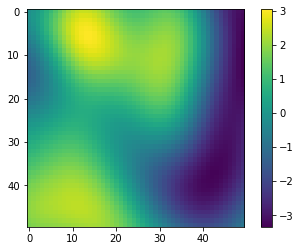

In [10]:
plt.imshow(source[10])
plt.colorbar()

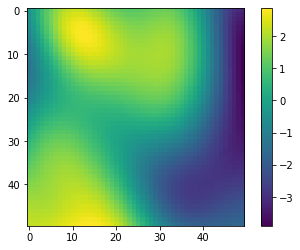

In [11]:
plt.imshow(source2[10])
plt.colorbar()